/Users/silver/Developer/Task2-Face-Generation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


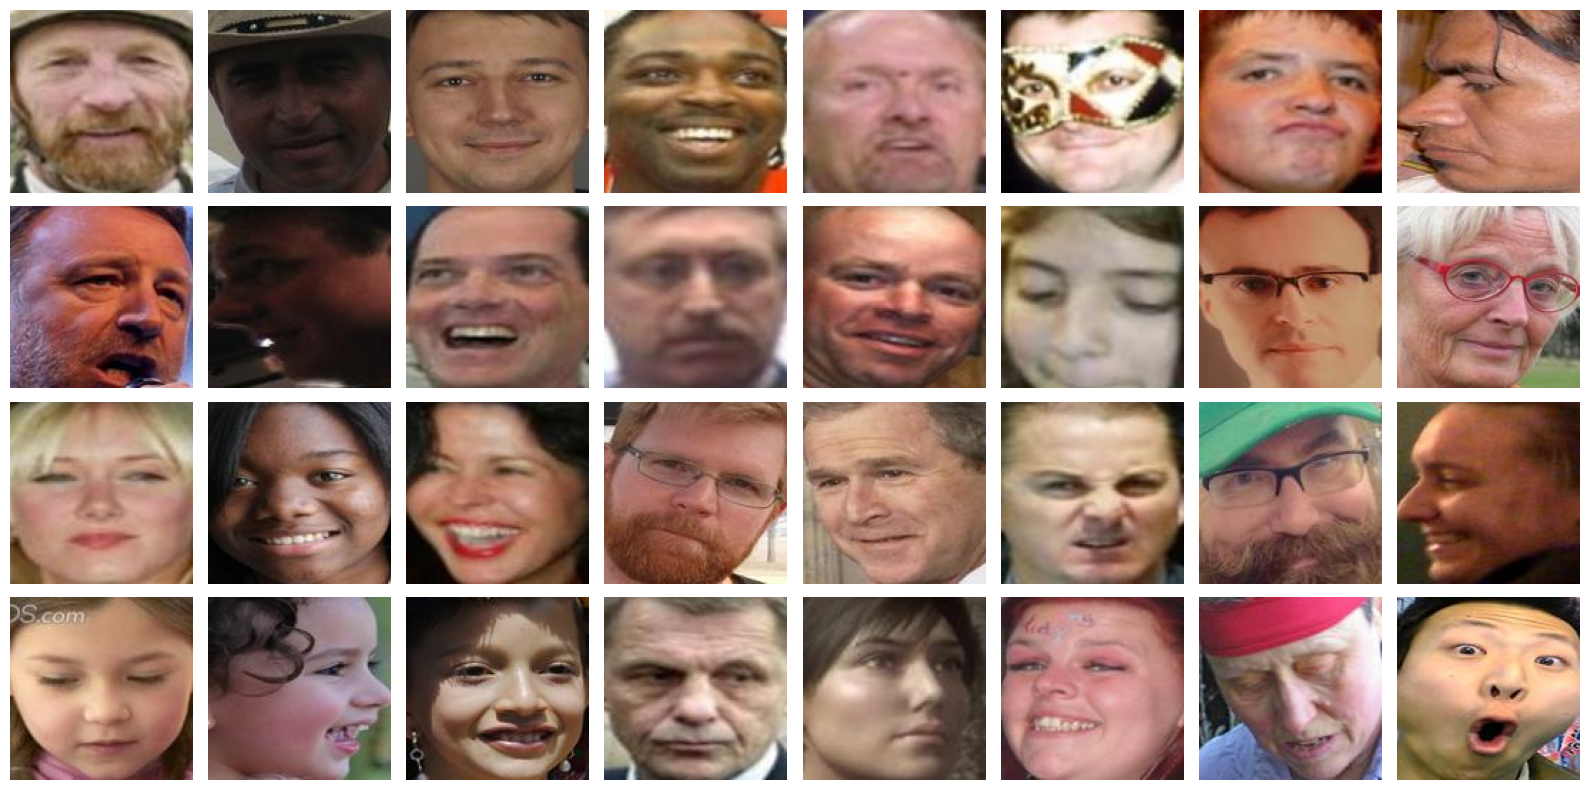

In [1]:
from PIL import Image
from faceGAN.dataset import FaceDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = FaceDataset(image_dir="data/val", train=False)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

def visualize_batch(batch):
    images = batch['image']
    
    images = images.permute(0, 2, 3, 1)  # Change shape to (batch_size, height, width, channels)
    
    images = (images * 0.5 + 0.5).clamp(0, 1)  # Rescale to [0, 1]
    images = images.numpy()  # Convert to numpy array for visualization
    
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()
visualize_batch(next(iter(dataloader)))

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
from faceGAN.networks import Generator
from torchmetrics.image.fid import FrechetInceptionDistance


generator = Generator()
generator.load_state_dict(torch.load('models/generator_512_final.pth'))
generator.eval()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
generator.to(device)

def calculate_fid(real_images: np.array, generated_images: np.array):
    fid = FrechetInceptionDistance(feature=64, normalize=True)
    
    real_images = torch.tensor(real_images).permute(0, 3, 1, 2)  # Change shape to (batch_size, channels, height, width)
    generated_images = torch.tensor(generated_images).permute(0, 3, 1, 2)
    
    fid.update(real_images, real=True)
    fid.update(generated_images, real=False)
    
    return fid.compute().item()

all_real_images = np.empty((0,3,128,128), dtype=np.float32)
all_fake_images = np.empty((0,3,128,128), dtype=np.float32)


for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    real_images = batch['image'].numpy()
    all_real_images = np.concatenate((all_real_images, real_images), axis=0)

    with torch.no_grad():
        generated_images = generator(batch['embedding'].to(device))

    all_fake_images = np.concatenate((all_fake_images, generated_images.cpu().numpy()), axis=0)

  0%|          | 0/57 [00:00<?, ?it/s]

### calculate similarity with the original embedding model chosen


In [3]:
#import cosine similarity
from torch.nn.functional import cosine_similarity

cosine_similarities=[]

for i in tqdm(range(0, len(all_real_images))):
    real_image = all_real_images[i]
    fake_image = all_fake_images[i]
    
    real_image = np.transpose(real_image, (1, 2, 0))  # Change shape to (height, width, channels)
    fake_image = np.transpose(fake_image, (1, 2, 0))
    
    real_image = Image.fromarray(((real_image * 0.5 + 0.5) * 255).astype(np.uint8))
    fake_image = Image.fromarray(((fake_image * 0.5 + 0.5) * 255).astype(np.uint8))
    
    real_image_embedding = dataset.get_embedding(real_image)
    fake_image_embedding = dataset.get_embedding(fake_image)
    
    cosine_similarity_value = cosine_similarity(
        torch.tensor(real_image_embedding).unsqueeze(0),
        torch.tensor(fake_image_embedding).unsqueeze(0)
    ).item()
    
    cosine_similarities.append(cosine_similarity_value)

mean_cosine_similarity = np.mean(cosine_similarities)

print(f"Maximum similarity: {np.max(cosine_similarities)}")
print(f"Mean Cosine Similarity: {mean_cosine_similarity}")
print(f"Minimum similarity: {np.min(cosine_similarities)}")
    

  0%|          | 0/1811 [00:00<?, ?it/s]

/var/folders/fd/6p_331rd77l_6jgjml95cygr0000gn/T/ipykernel_46400/2563757874.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(real_image_embedding).unsqueeze(0),
/var/folders/fd/6p_331rd77l_6jgjml95cygr0000gn/T/ipykernel_46400/2563757874.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fake_image_embedding).unsqueeze(0)


Maximum similarity: 0.709871232509613
Mean Cosine Similarity: 0.15235713674930607
Minimum similarity: -0.26669350266456604
